## 0 - IMPORTAÇAO DAS BIBLIOTECAS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from IPython.core.display import HTML
from IPython.display import Image
import datetime

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Logo abaixo fazendo a junção com o Merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


## 1 - Copia dos Dados

In [3]:
## Copia dos dados

df1 = df_raw.copy()

In [4]:
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
## Aqui pode ler o dataframe com o comando sample para vir qualquer numero aleatorio 

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
747156,892,6,2013-08-31,4032,394,1,0,0,0,a,a,19370.0,4.0,2002.0,0,NaN,NaN,NaN
763904,915,5,2013-08-16,8102,635,1,1,0,1,d,c,650.0,3.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
25461,932,4,2015-07-09,6163,679,1,0,0,0,a,a,15700.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
15893,284,5,2015-07-17,5666,479,1,1,0,0,d,a,1290.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
999838,469,3,2013-01-16,8447,1273,1,0,0,0,c,c,710.0,9.0,2005.0,0,NaN,NaN,NaN


## 1.1 - Renomear as Colunas

In [6]:
## Exibe os nomes das colunas

df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Dimensao do Dataframe

In [9]:
print ('O numero total de linhas são: {}'.format(df1.shape[0]))
print ('O numero total de colunas são: {}'.format(df1.shape[1]))

O numero total de linhas são: 1017209
O numero total de colunas são: 18


## 1.3 - Tipos de dados

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check de NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Tratamento dos NA ou Seja ( Não Aplicada) - Dados faltantes

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 


In [14]:
df1.sample(5).T

,69310,490595,416843,156098,164182
store,181,781,619,1114,278
day_of_week,6,5,1,6,5
date,2015-05-30 00:00:00,2014-04-18 00:00:00,2014-06-23 00:00:00,2015-03-14 00:00:00,2015-03-06 00:00:00
sales,3215,0,3650,20533,7432
customers,364,0,431,3230,841
open,1,0,1,1,1
promo,0,1,0,0,1
state_holiday,0,b,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a


## 1.6 - Change Types

In [15]:
## Mudando algumas colunas para inteiro, pois estavam como float

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Estatistica descritiva

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [17]:
# Variaveis numericas
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
941302,1028,7,0,0,0,0,0,150.0,3,2013,1,31,2013,0
22450,151,6,6115,614,1,0,0,4360.0,10,2005,0,28,2015,0


In [18]:
# Variaveis Categoricas
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
485279,0,a,a,"Jan,Apr,Jul,Oct",Apr
865690,0,a,a,"Mar,Jun,Sept,Dec",May


## 1.7.1 - Atributos numericos

In [19]:
# Central e tendencia - media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T

# Dispersão - Desvio padrão - STD, maximo, minimo, range (valor entre o minimo e maximo), Skew e Kurtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

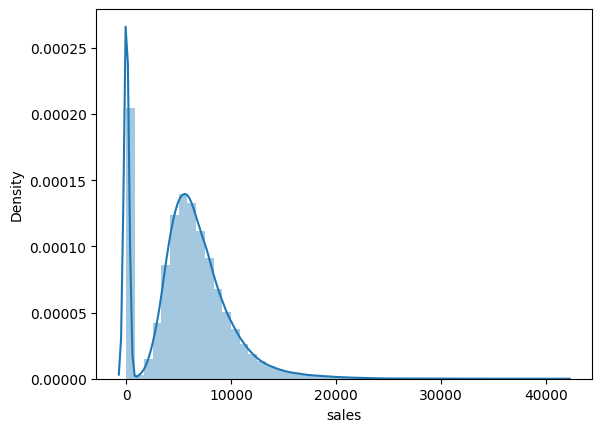

In [20]:
sns.distplot(df1['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

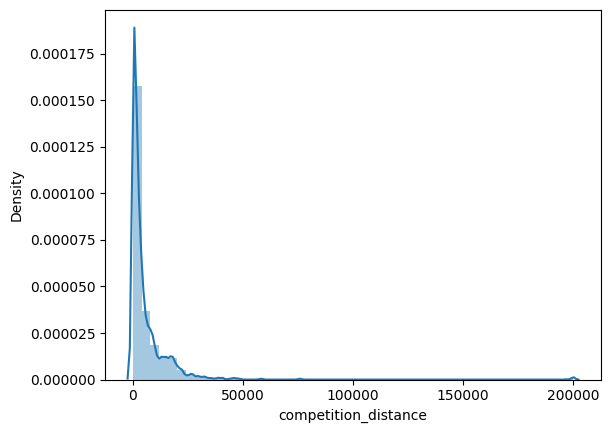

In [21]:
sns.distplot(df1['competition_distance'])

## 1.7.2 - Dados Categoricos

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

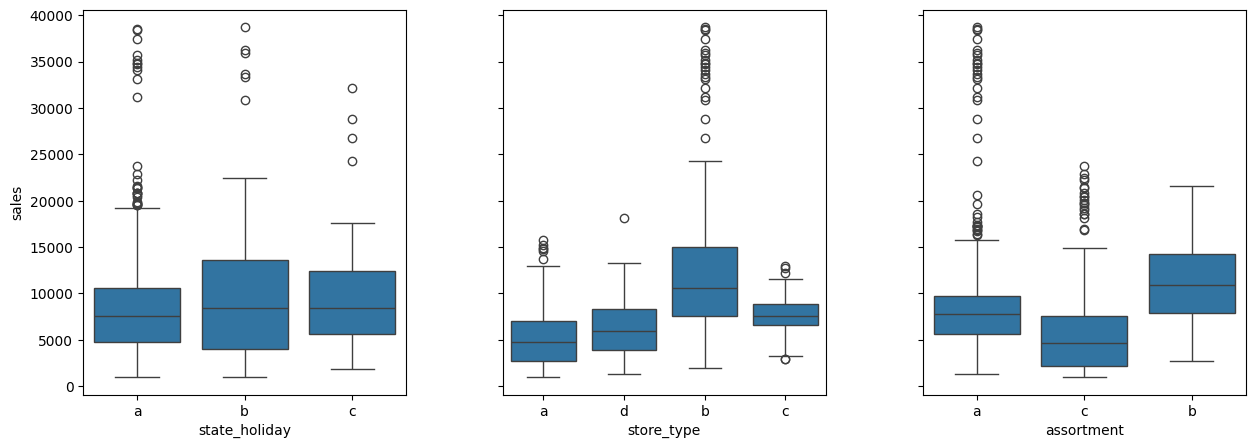

In [23]:
# Crie uma figura com subplots e defina o tamanho da figura e o espaçamento horizontal
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.3)  # Ajuste o espaçamento horizontal

# Seu código para os subplots
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])  # Usando o primeiro subplot
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])  # Usando o segundo subplot
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])  # Usando o terceiro subplot

plt.show()

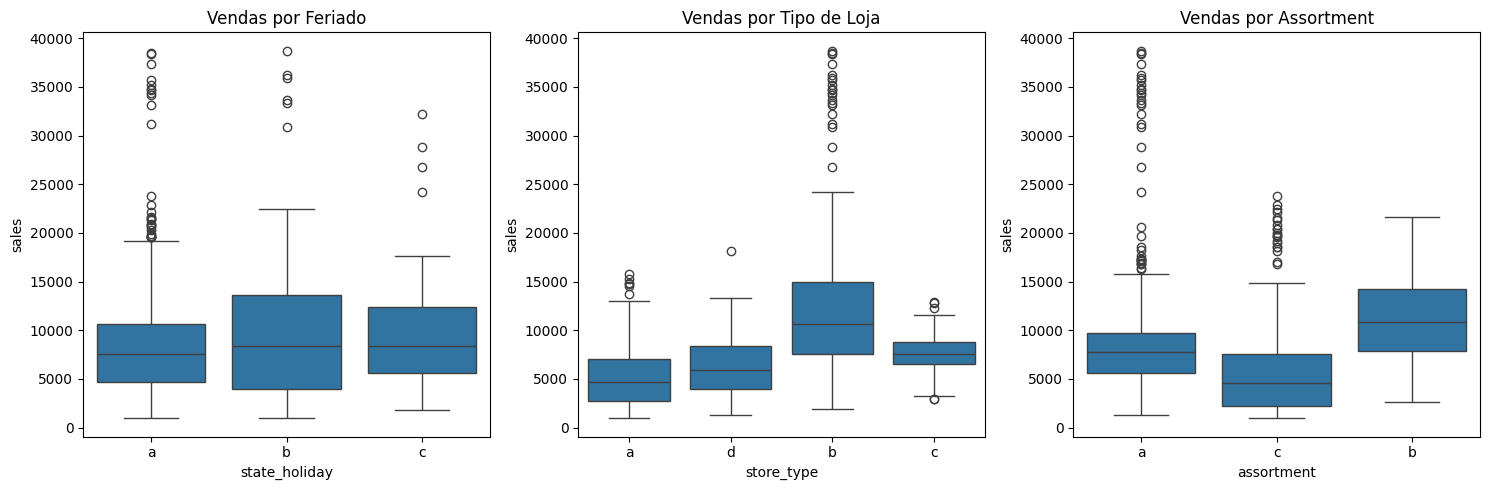

In [24]:
# Filtrar os dados
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criar uma figura com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_title('Vendas por Feriado')

# Gráfico 2
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_title('Vendas por Tipo de Loja')

# Gráfico 3
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_title('Vendas por Assortment')

# Ajustar o espaçamento entre os gráficos
plt.tight_layout()

# Exibir a figura
plt.show()

In [25]:

# Suponha que você já tem seus dados em 'df1' e 'aux1' foi criado como indicado na pergunta

# Ajuste o tamanho da figura
plt.figure(figsize=(12, 2))

# Crie os subplots com um espaçamento adequado
#plt.subplot(1, 3, 1)
#sns.boxplot(x='state_holiday', y='sales', data=aux1)
#plt.title('State Holiday')

#plt.subplot(1, 3, 2)
#sns.boxplot(x='store_type', y='sales', data=aux1)
#plt.title('Store Type')

#plt.subplot(1, 3, 3)
#sns.boxplot(x='assortment', y='sales', data=aux1)
#plt.title('Assortment')

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()

# Exiba os gráficos interativamente usando Plotly


fig = px.box(aux1, x='state_holiday', y='sales')
fig.update_layout(title='State Holiday')
fig.show()

fig = px.box(aux1, x='store_type', y='sales')
fig.update_layout(title='Store Type')
fig.show()

fig = px.box(aux1, x='assortment', y='sales')
fig.update_layout(title='Assortment')
fig.show()

<Figure size 1200x200 with 0 Axes>

## 2.0 - Feature Engineering


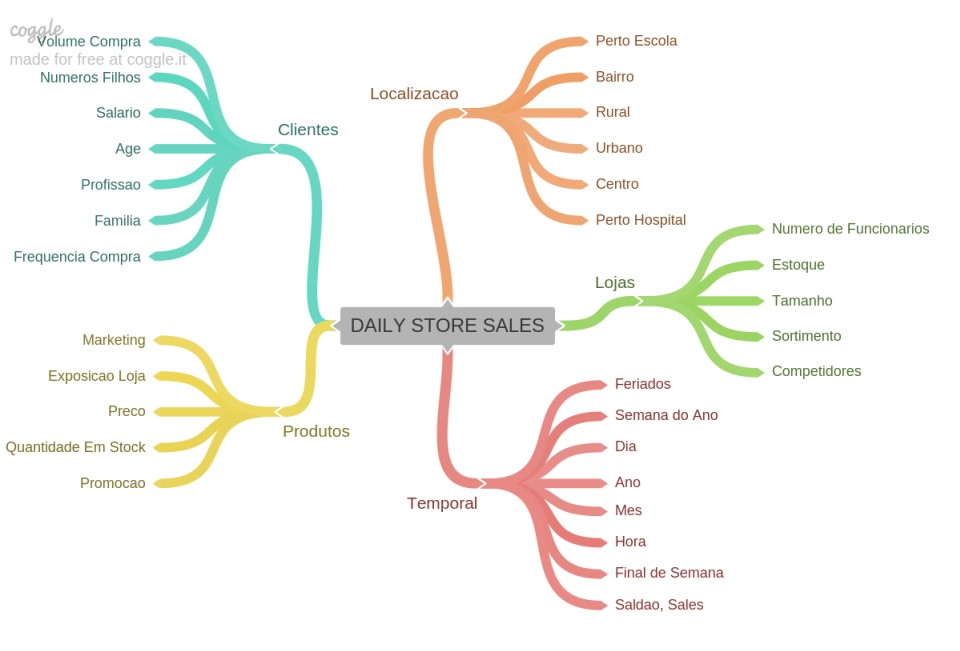

In [26]:
Image('img/mapa_mental.jpg')

In [27]:
df2 = df1.copy()

In [28]:
# - Year - Ano

df2['year'] = df2['date'].dt.year

# - Month - Mes

df2['month'] = df2['date'].dt.month

# - Day - Dia

df2['day'] = df2['date'].dt.day

# - week_of_year - Semana do ano

#df2['week_of_year'] = df2['date'].dt.weekday

# - year week - Ano da semana

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# - Competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)

# - promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# - Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# - State holiday - feriados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')


In [29]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 - Filtragem de variavel

In [30]:
df3 = df2.copy()

In [31]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 - Filtragem das linhas

In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [33]:
# - Limpando as colunas que não fazem relevancia no projeto

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'year_week', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 Analise Exploratoria de Dados

In [35]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Variaveis de Resposta

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\1473926699.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

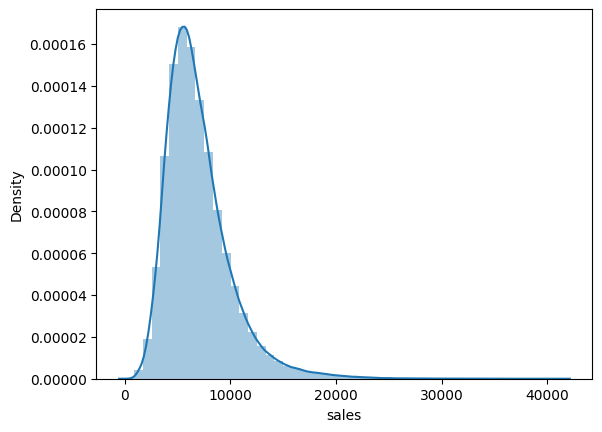

In [36]:
sns.distplot(df4['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\167578569.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

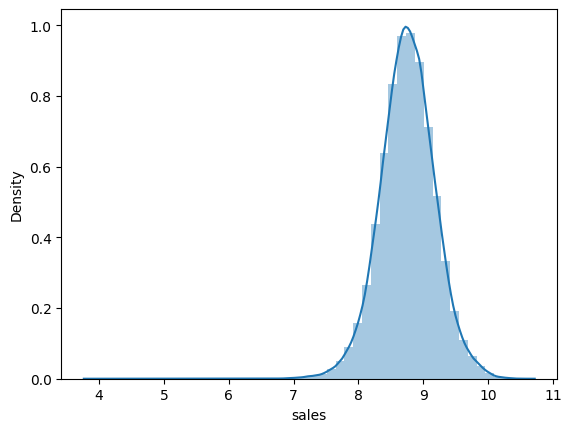

In [56]:
# Aqui utilizando o log1p para chegar mais proximo de uma variavel normal

sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Variaveis Numericas

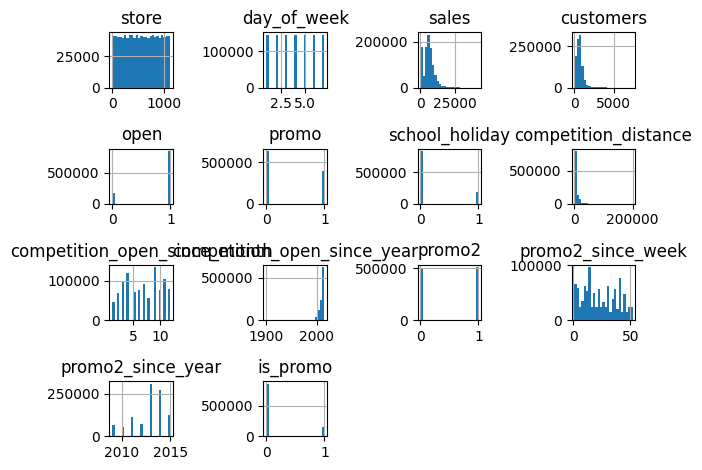

In [38]:
num_attributes.hist(bins=25);

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Mostrar os gráficos
plt.show()

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\3062526336.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='store'>

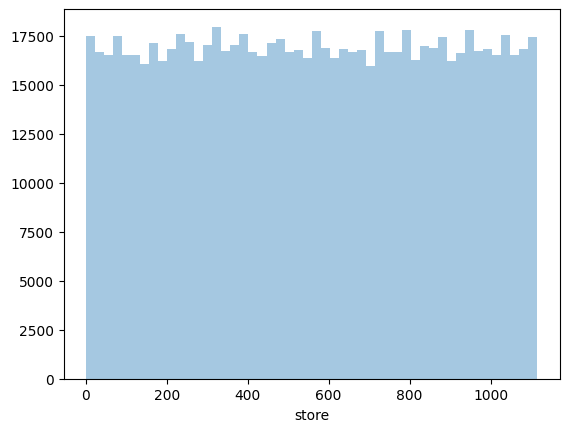

In [39]:
sns.distplot(df4['store'],kde=False) # com o kde=False ele não tras a curva

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\2659470640.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\2659470640.py:14: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\2659470640.py:15: UserWarning:



`distplot`

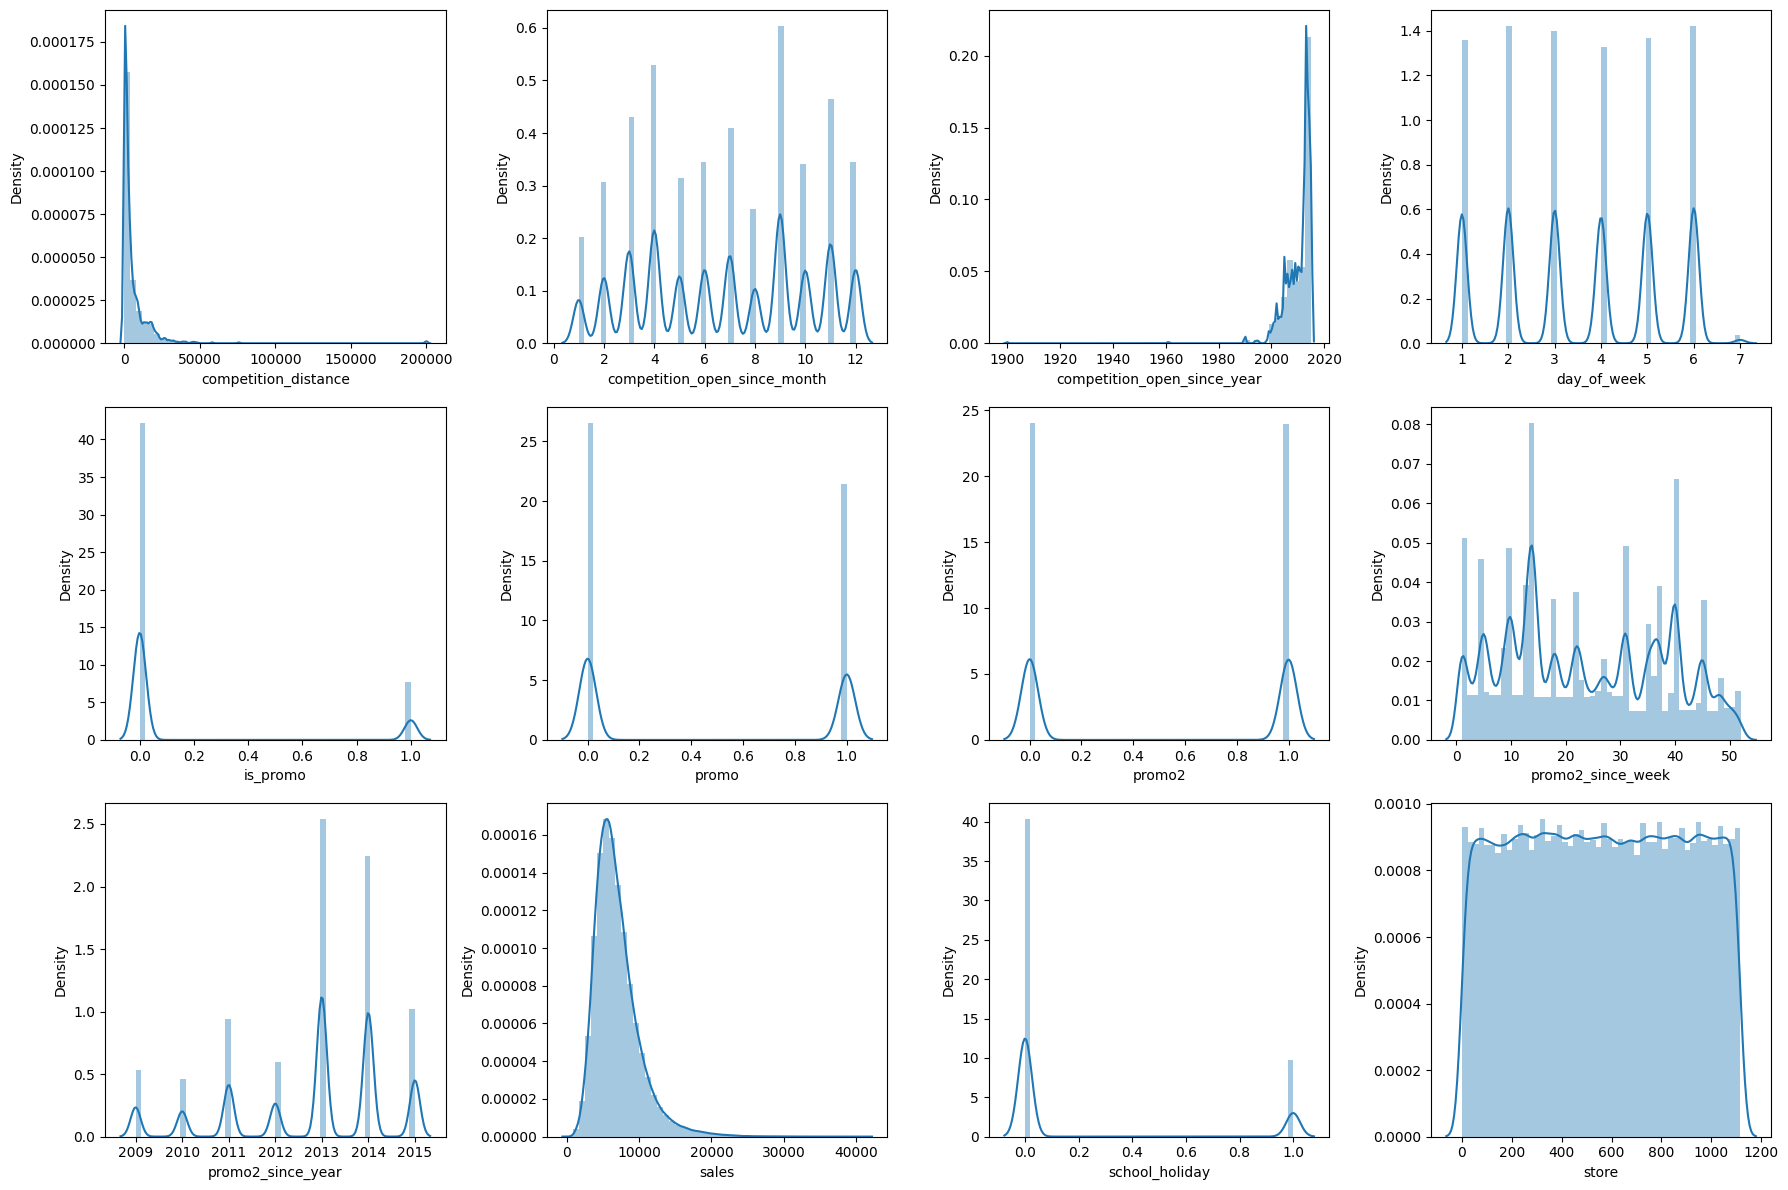

In [40]:
# Suponha que você tenha um DataFrame chamado df4 com os dados

# Crie uma figura com subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))


# Colunas dropadas
#customers', 'open', 'promo_interval', 'month_ma

# Agora, você pode usar sns.distplot para desenhar cada gráfico em um subplot específico
sns.distplot(df4['competition_distance'], ax=axes[0, 0])
#axes[0, 0].set_title('Distribuição da loja')

sns.distplot(df4['competition_open_since_month'], ax=axes[0, 1])
sns.distplot(df4['competition_open_since_year'], ax=axes[0, 2])
sns.distplot(df4['day_of_week'], ax=axes[0, 3])
sns.distplot(df4['is_promo'], ax=axes[1, 0])
sns.distplot(df4['promo'], ax=axes[1, 1])
sns.distplot(df4['promo2'], ax=axes[1, 2])
sns.distplot(df4['promo2_since_week'], ax=axes[1, 3])
sns.distplot(df4['promo2_since_year'], ax=axes[2, 0])
sns.distplot(df4['sales'], ax=axes[2, 1])
sns.distplot(df4['school_holiday'], ax=axes[2, 2])
sns.distplot(df4['store'], ax=axes[2, 3])

# Vamos supor que você tenha mais dados para outros gráficos
# Por exemplo:
# sns.scatterplot(x=df4['coluna1'], y=df4['coluna2'], ax=axes[0, 1])
# axes[0, 1].set_title('Gráfico de dispersão')

# Você pode adicionar mais gráficos conforme necessário

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### 4.1.3 Variaveis Categoricas

In [41]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [42]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    Easter_holiday
241126         Christmas
Name: state_holiday, dtype: object

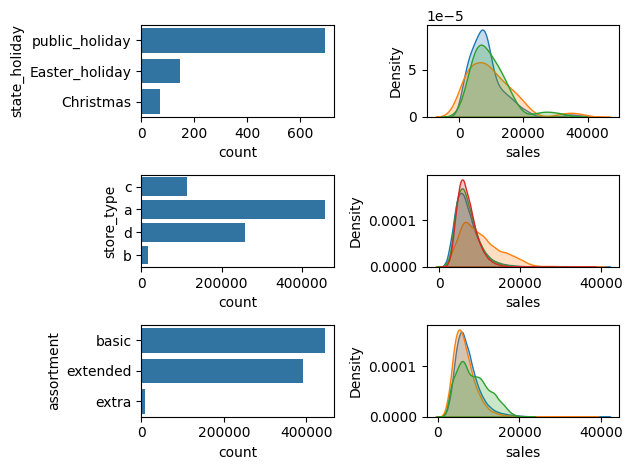

In [43]:
# State Holidays

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter_holiday']['sales'], label='Easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', fill=True)

# Store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)


# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)


# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()


## 4.2 Analise Bivariada

### H1 - As lojas que tem um mix mais variado de produtos deveriam vender mais ?
#### FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_19672\560123680.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




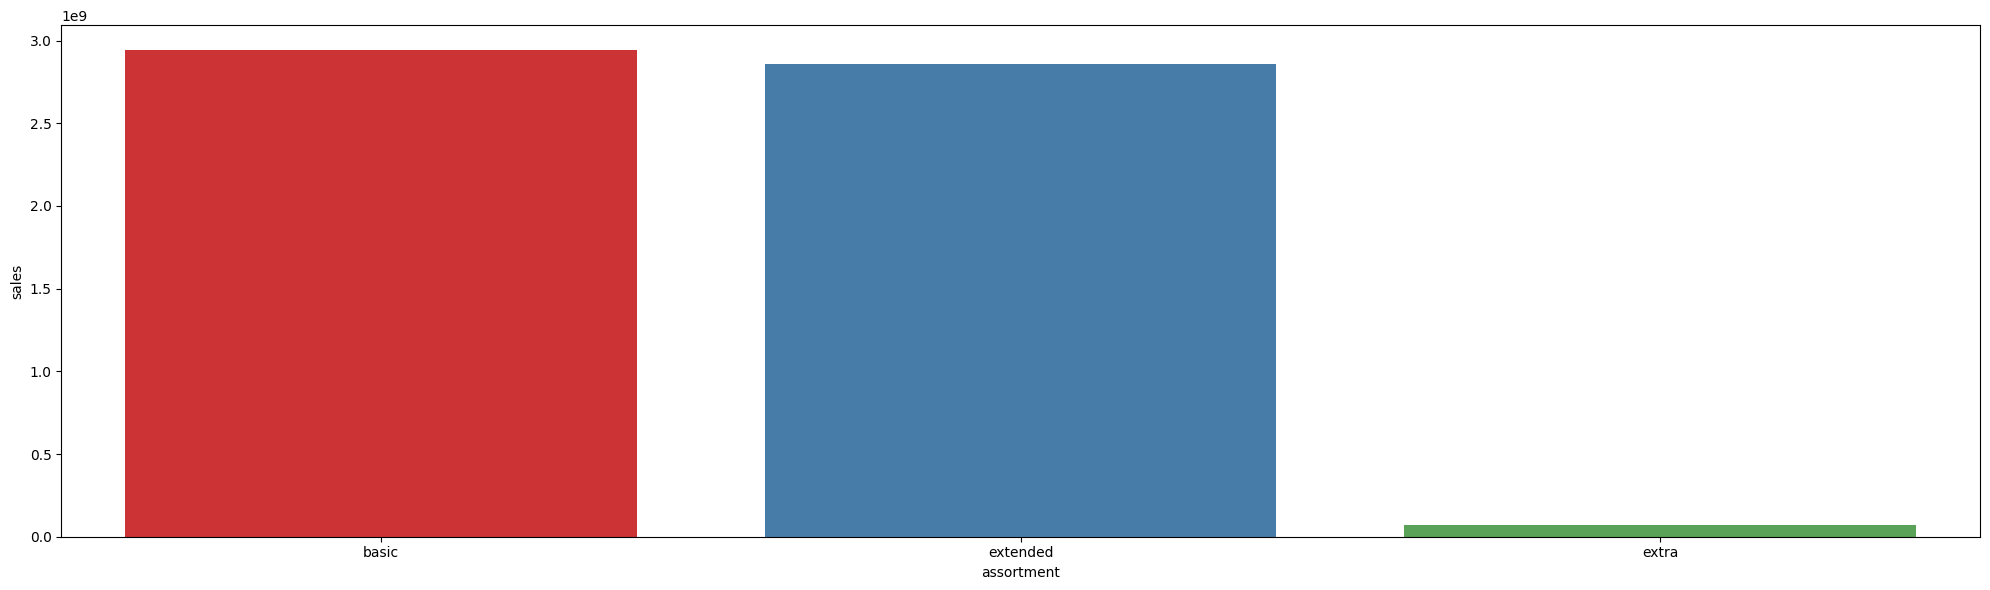

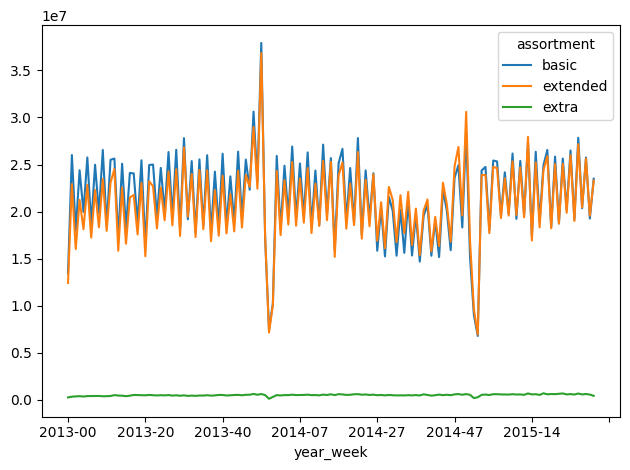

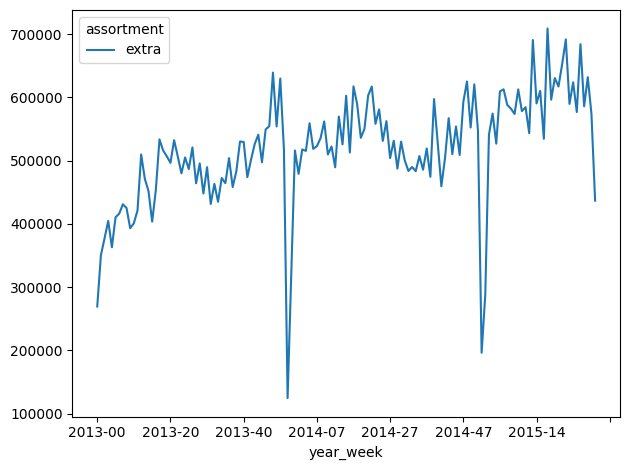

In [44]:
# As lojas que tem um mix mais variado de produtos deveriam vender mais ?

# - FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

# Defina sua paleta de cores personalizada como uma lista de cores

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(20, 6))
sns.barplot(x='assortment', y='sales', data=aux1, palette='Set1');

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H2 - Lojas com competidores mais proximos deveriam vender menos

#### FALSA - Lojas com COMPETIDORES mais proximos vendem MAIS

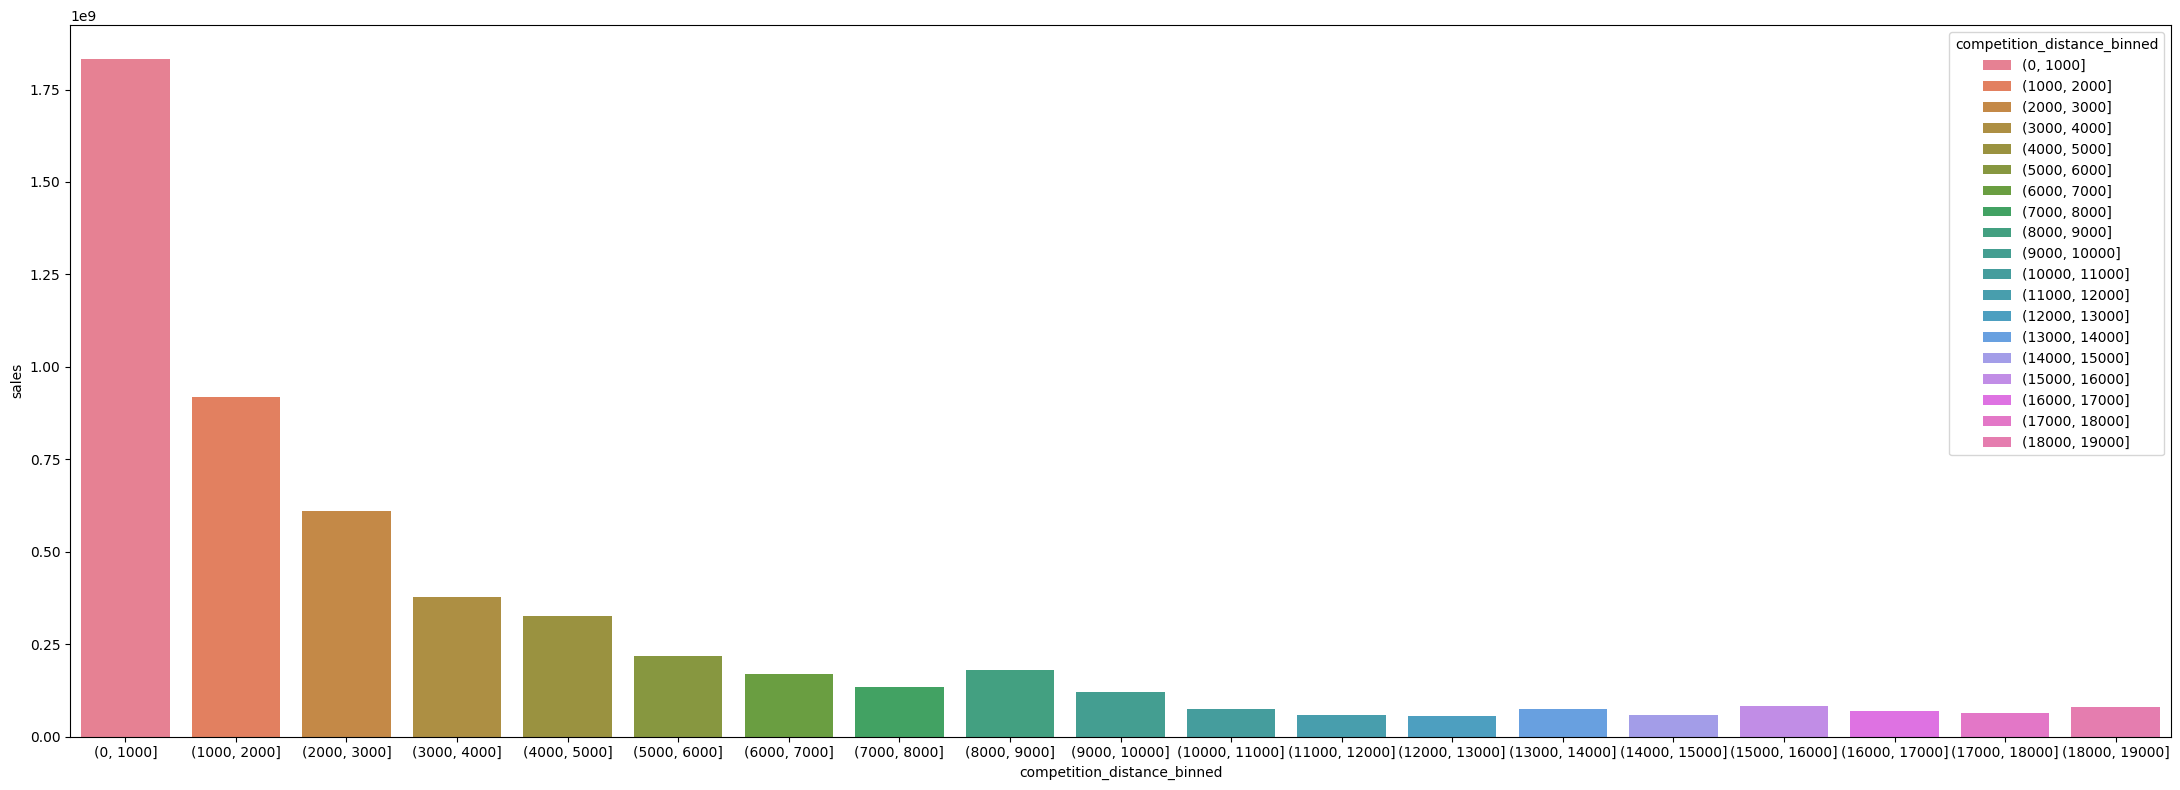

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


plt.figure(figsize=(22, 8))
#sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='Set1');
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned');
# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

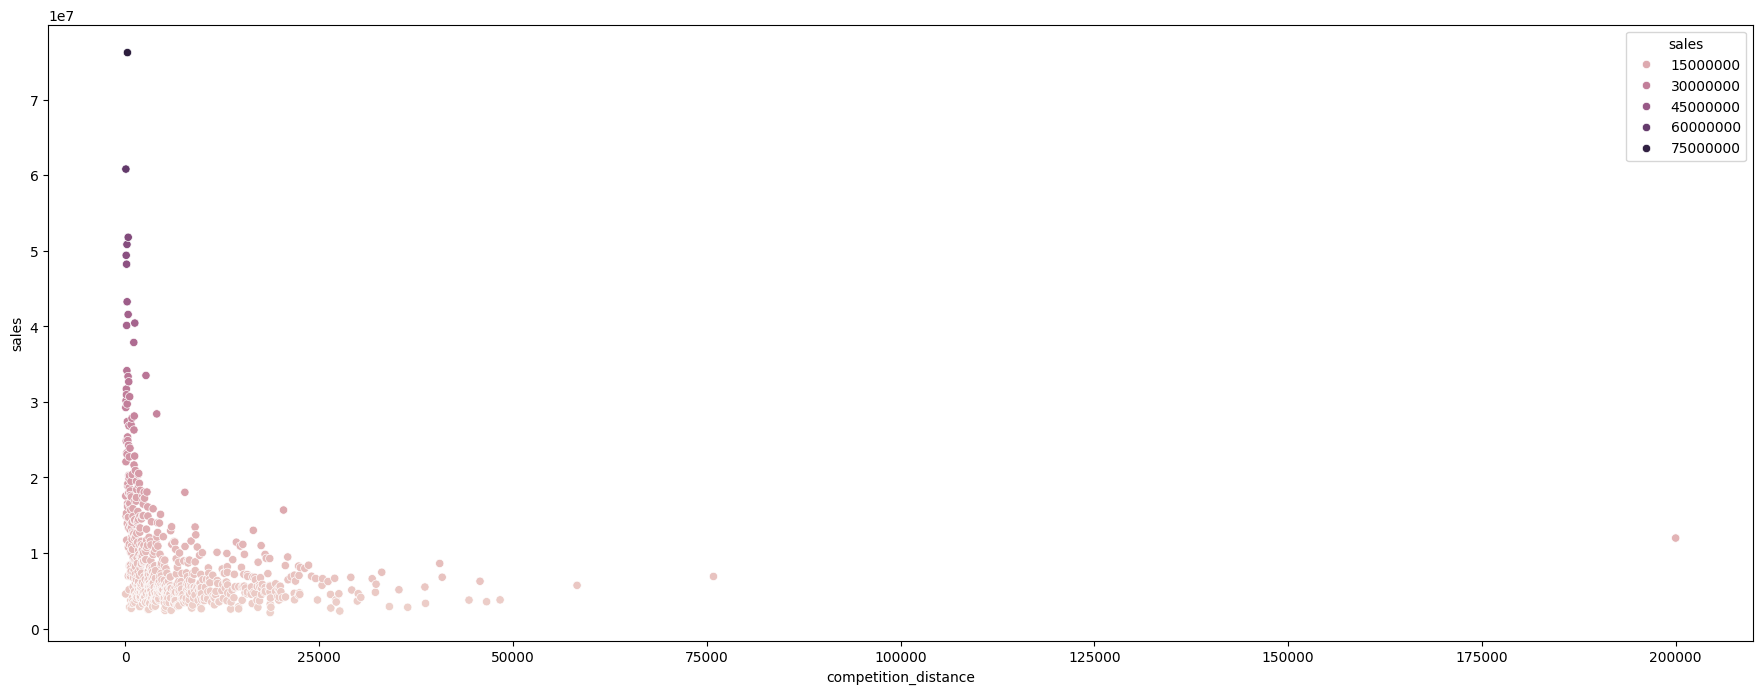

In [46]:
# Fazendo graficos com o scatterplot

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(22, 8))
sns.scatterplot(x='competition_distance', y='sales', data=aux1, hue='sales');


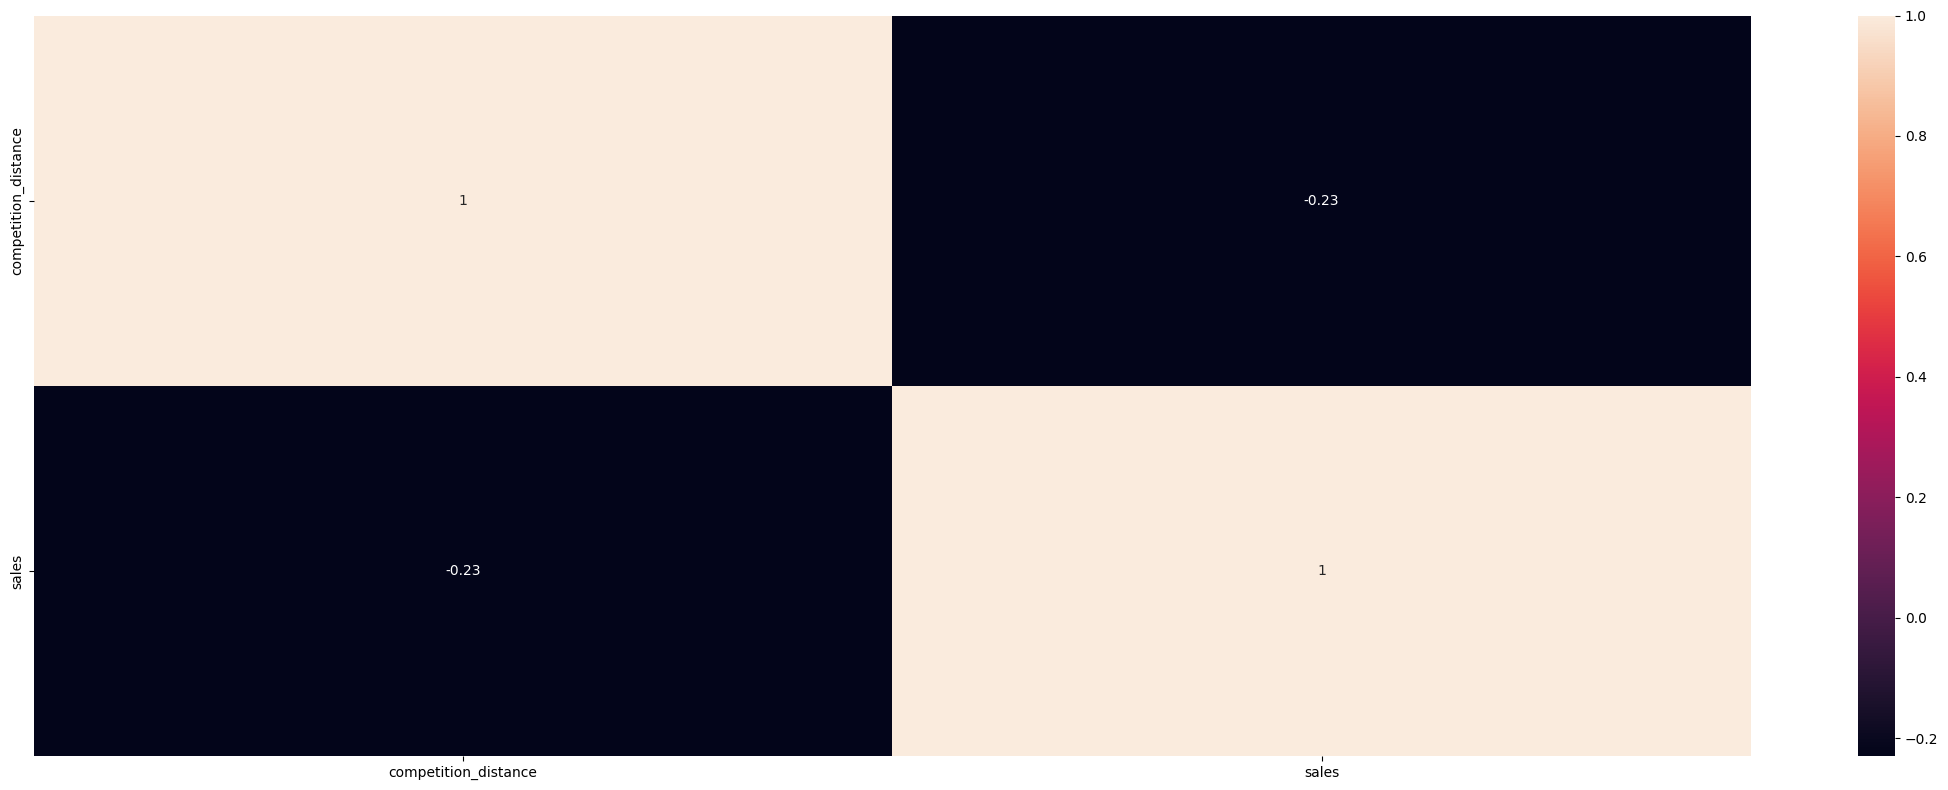

In [47]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H3 Lojas com competidores à mais tempo deveriam vender mais

#### É FALSO - > Lojas com COMPETIDORES à mais tempo VENDEM MENOS

In [48]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(22, 8))

#sns.barplot(x='competition_open_since_month', y='sales', data=aux1, hue='competition_open_since_month' )

fig = px.bar(aux2, x='competition_time_month', y='sales', color='competition_time_month')

# Atualize o layout do gráfico para evitar sobreposição de rótulos
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    xaxis_title='Competicap por Mes',
    yaxis_title='Sales',
    title='Vendas por Mês de Abertura da Concorrência'
)

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura

fig.show()

<Figure size 2200x800 with 0 Axes>

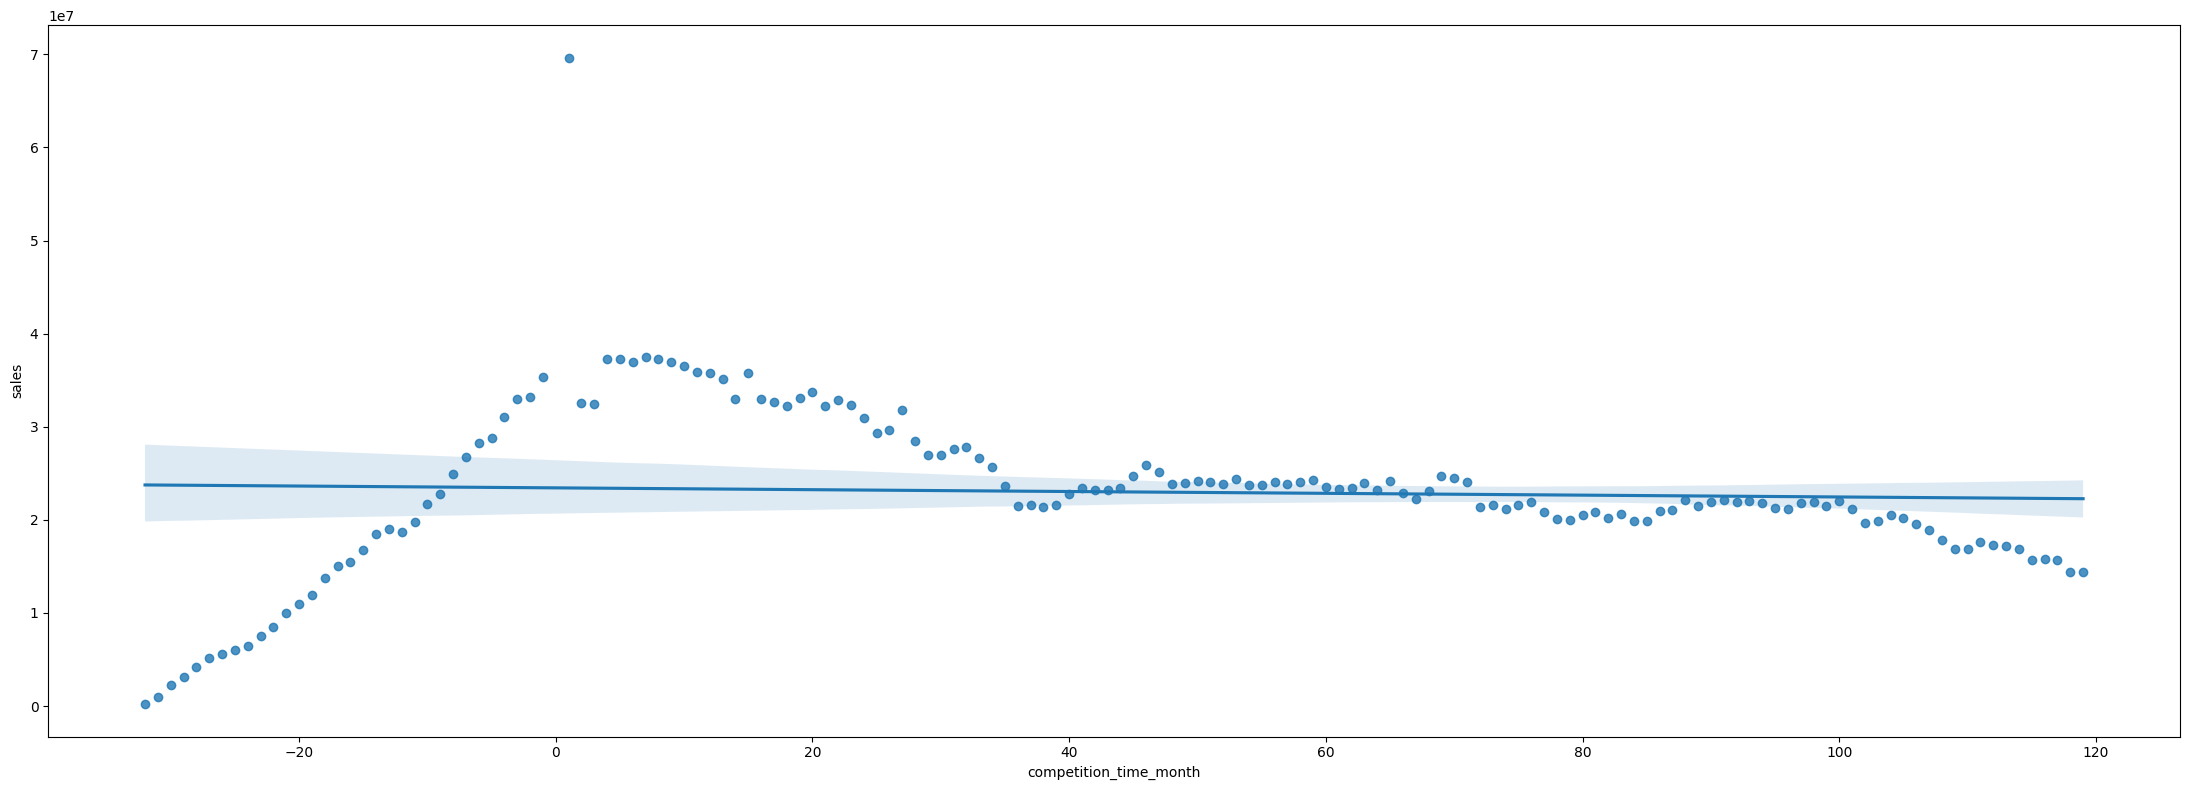

In [49]:
plt.figure(figsize=(22, 8))

sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.tight_layout()

# Exiba a figura

plt.show()

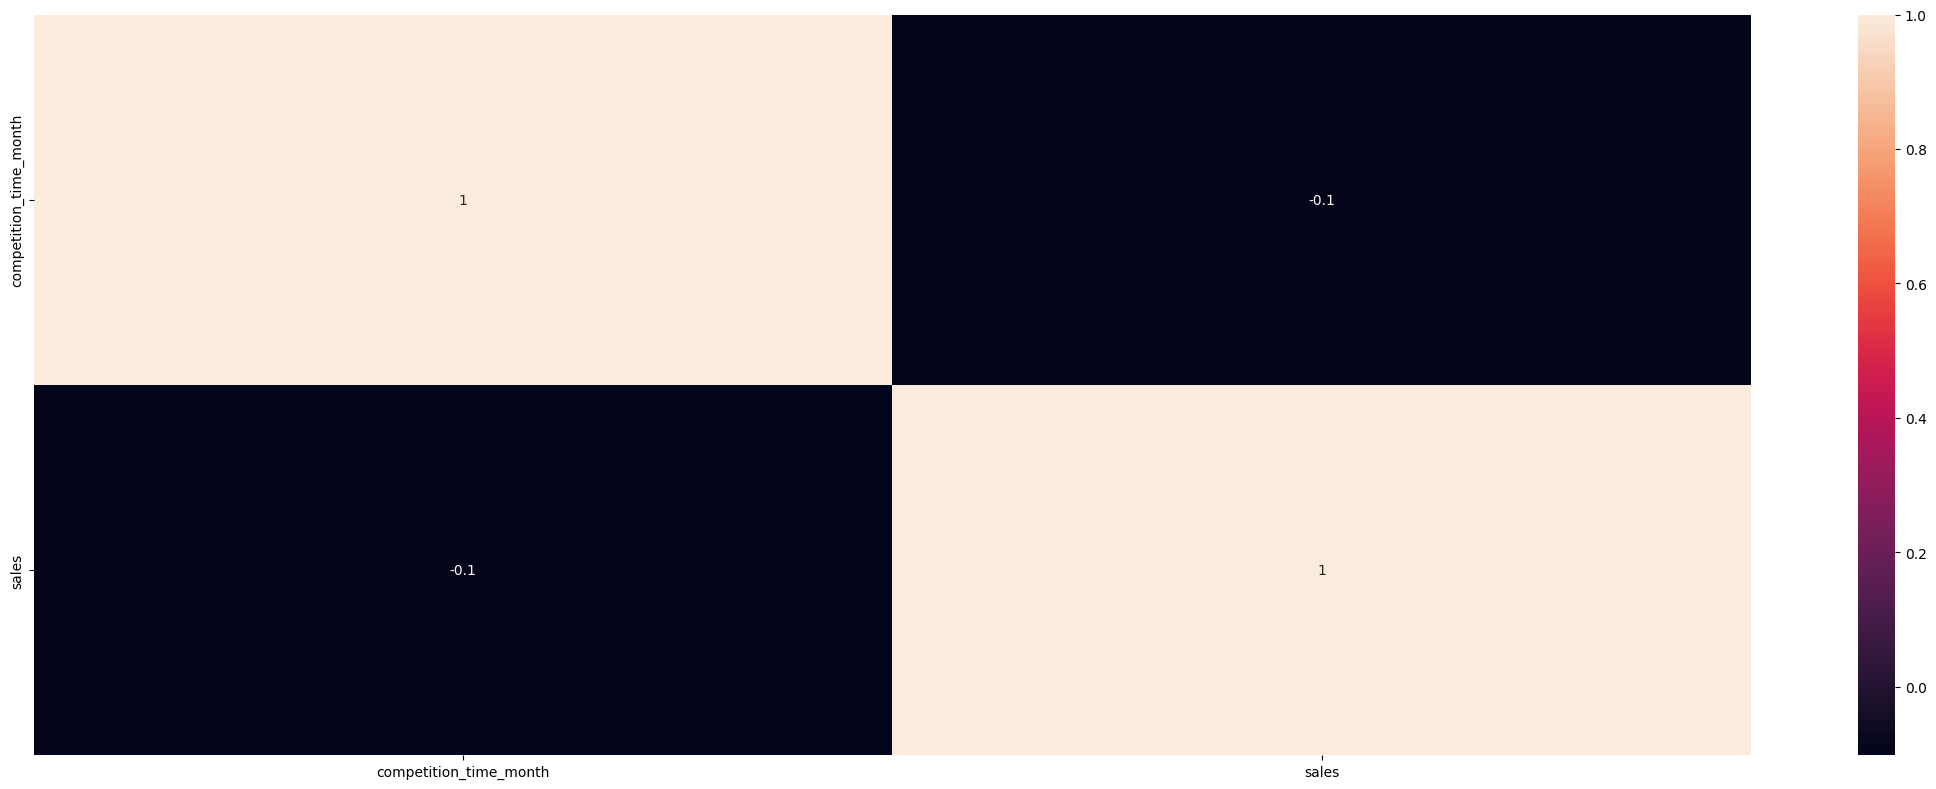

In [50]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais

#### **FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promoção

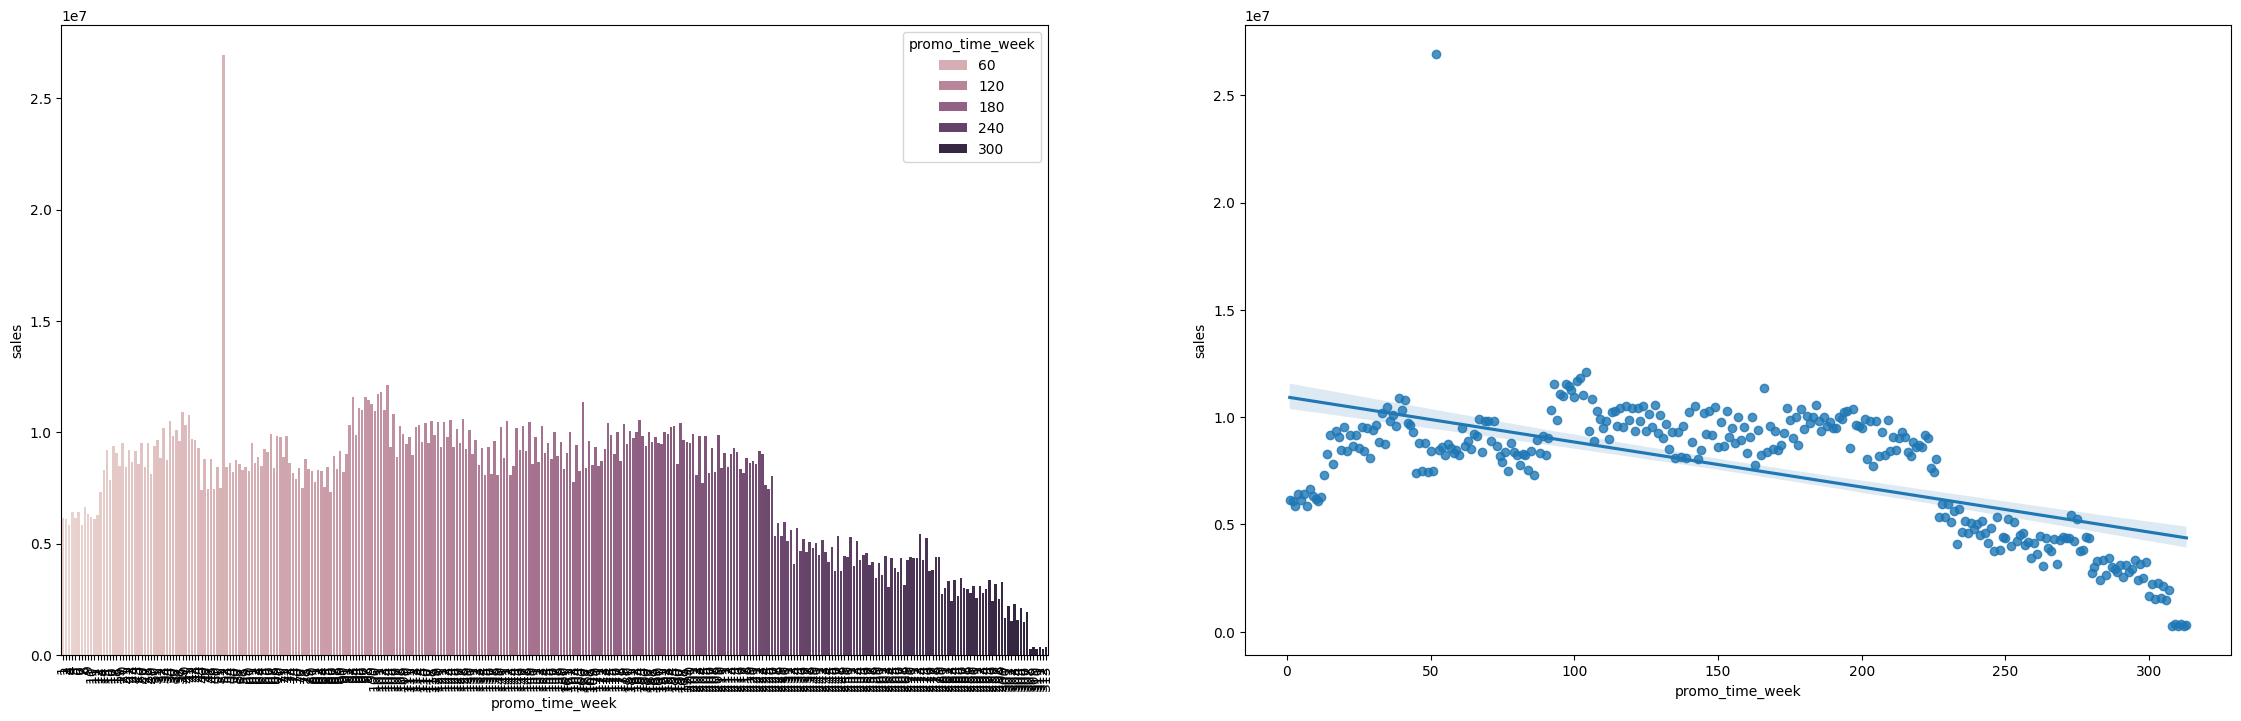

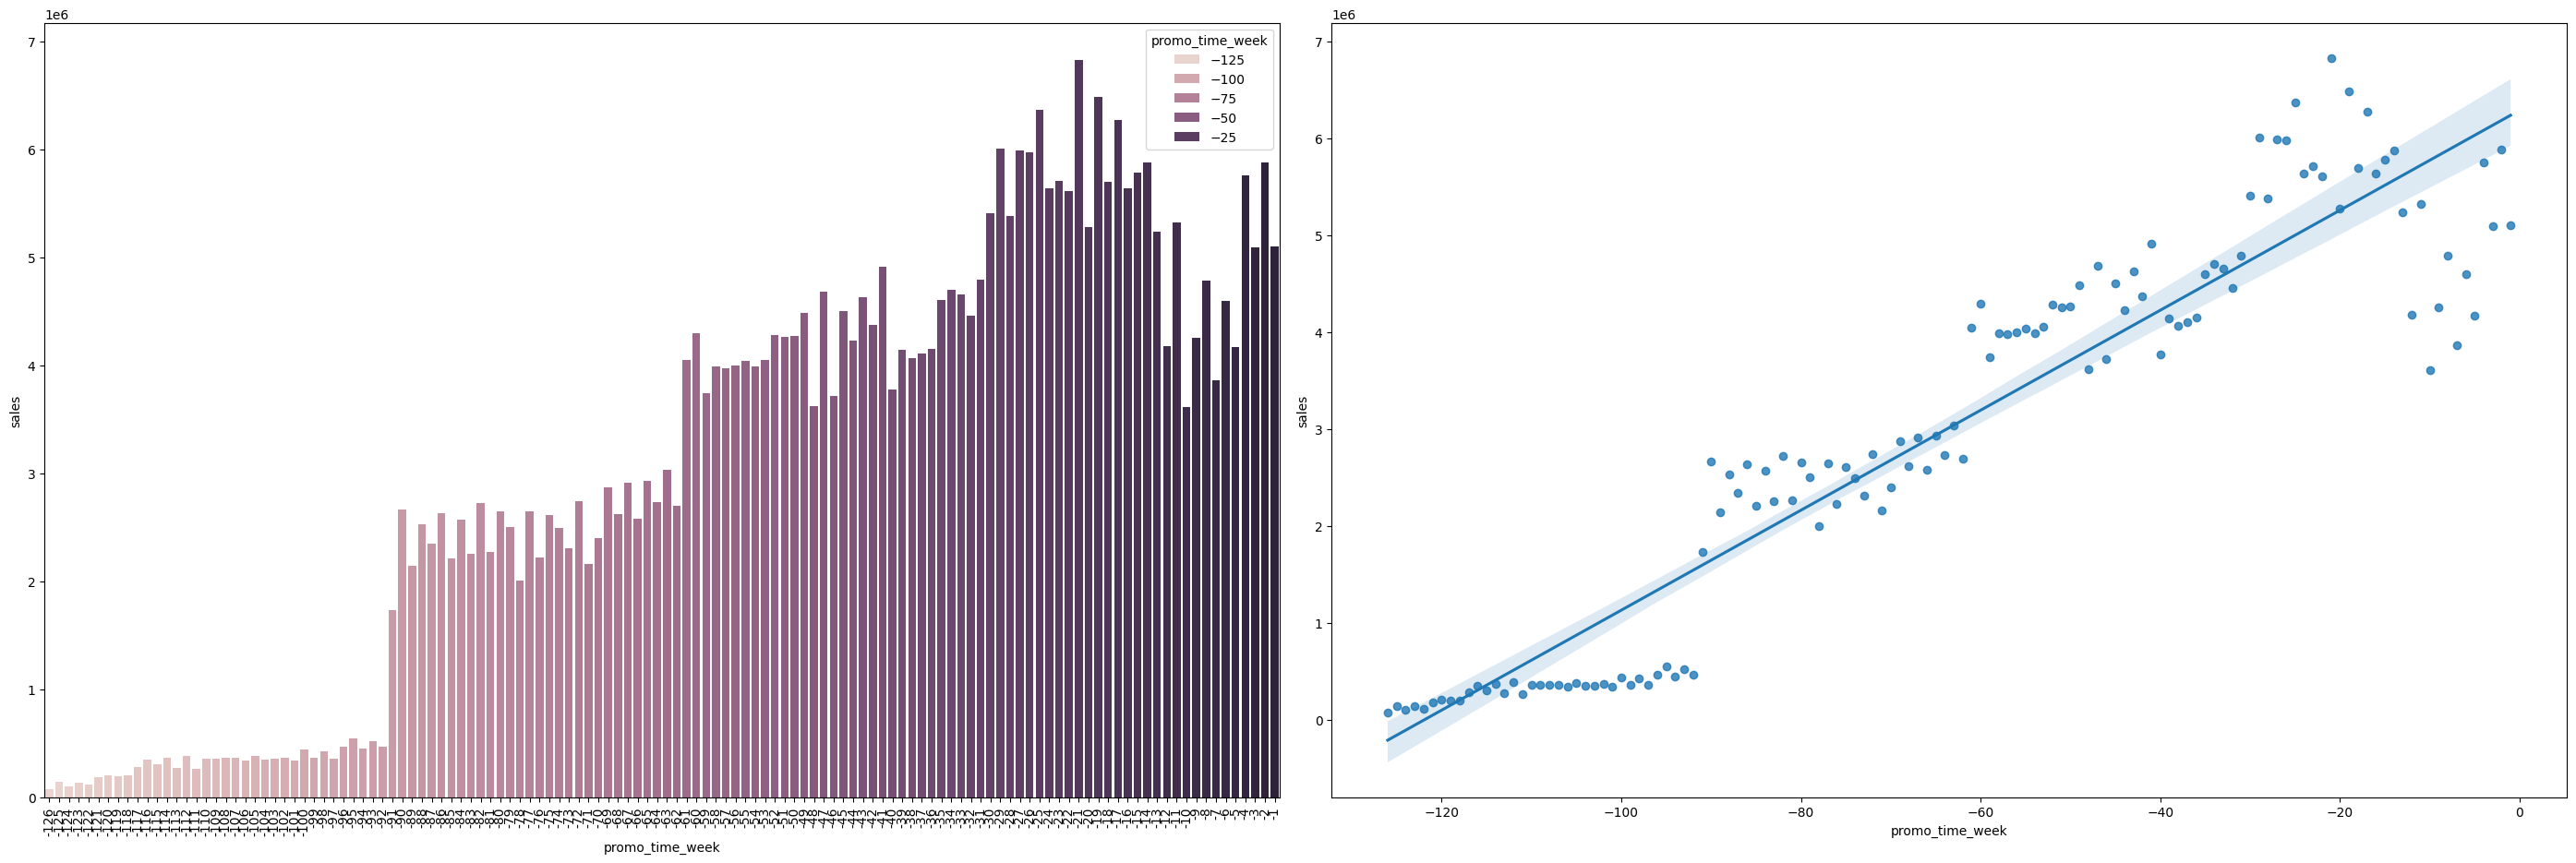

In [51]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(28, 18))
plt.subplot(2,2,1)

aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week')
plt.xticks(rotation=90);


plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.figure(figsize=(28, 18))
plt.subplot(2,2,3)

aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week')
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

<Axes: >

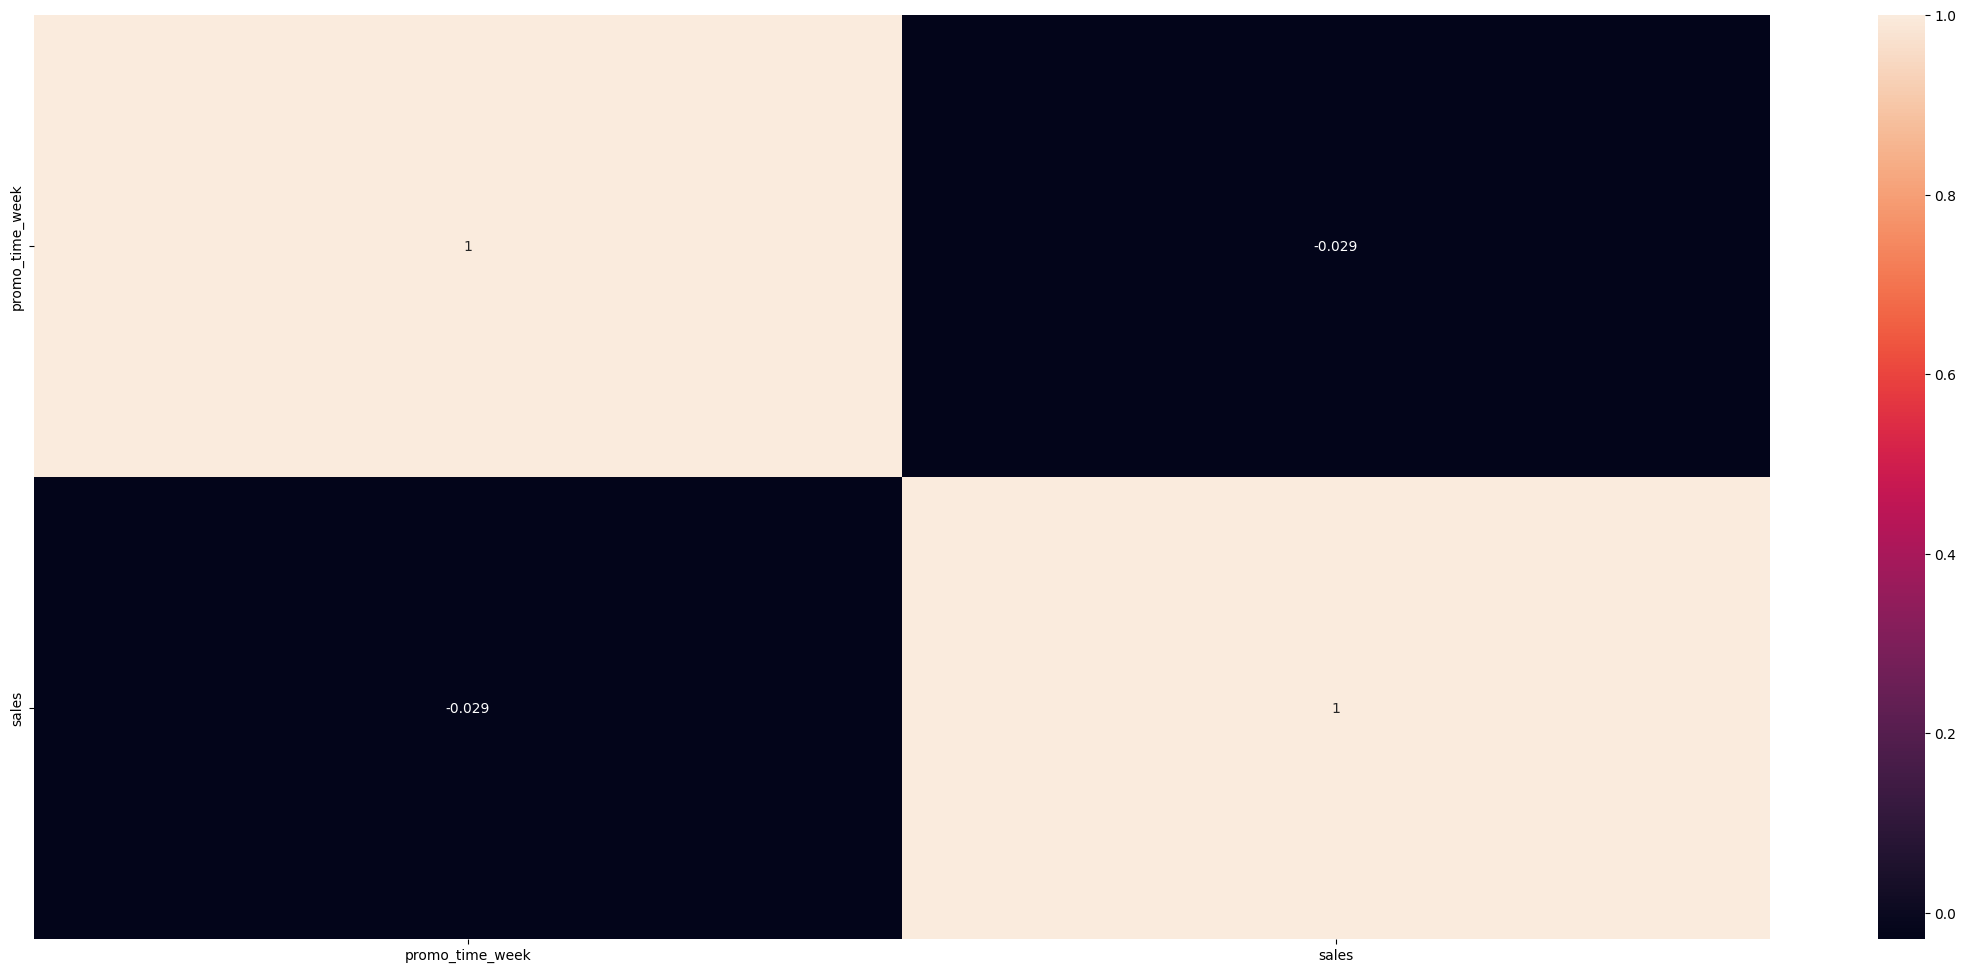

In [52]:
plt.figure(figsize=(28, 12))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5 Lojas com mais dias de promoção deveriam vender mais (Faremos uma segunda analise mais para frente)

### H6 Lojas com mais promoções consecutivas deveriam vender mais
#### **FALSA** Lojas com promocoes consecutivas vendem menos

In [53]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Veja que neste quadro as lojas que participaram somente da promo e não participaram da promo2 se sairam melhores em vendas

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


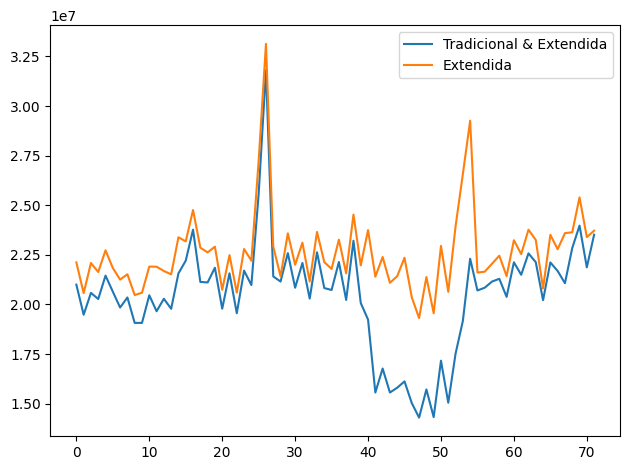

In [54]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H8 - Lojas abertas durante o feriado de Natal deveriam vender mais
#### **FALSA** Lojas abertas durante o Natal VENDEM MENOS

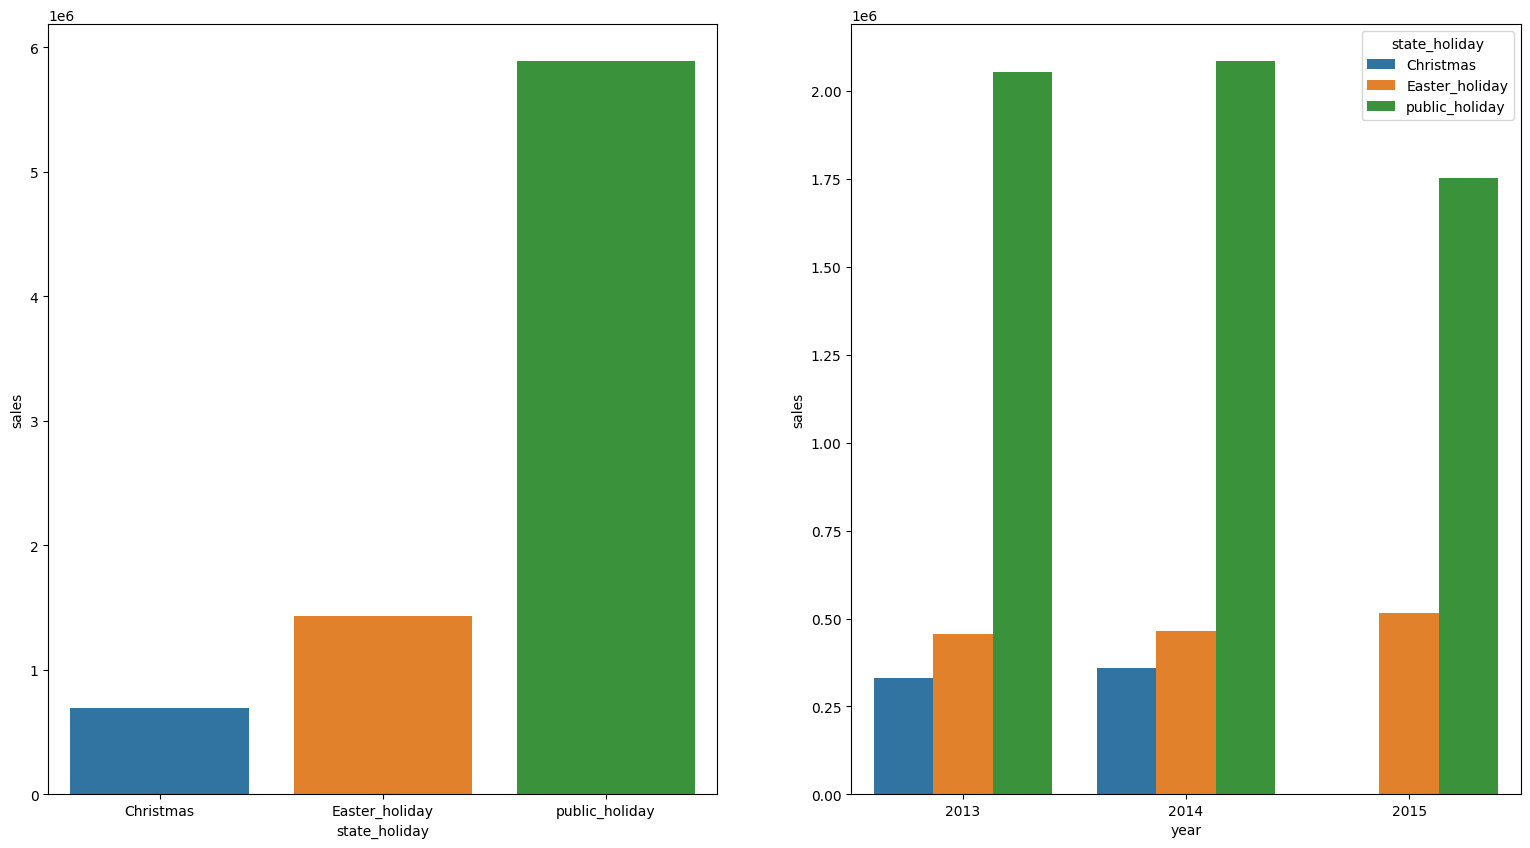

In [77]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(19, 10))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

#plt.figure(figsize=(19, 10))
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H9 - Lojas deveriam vender mais ao longo dos anos
#### **FALSA** Lojas vendem menos ao passar dos anos

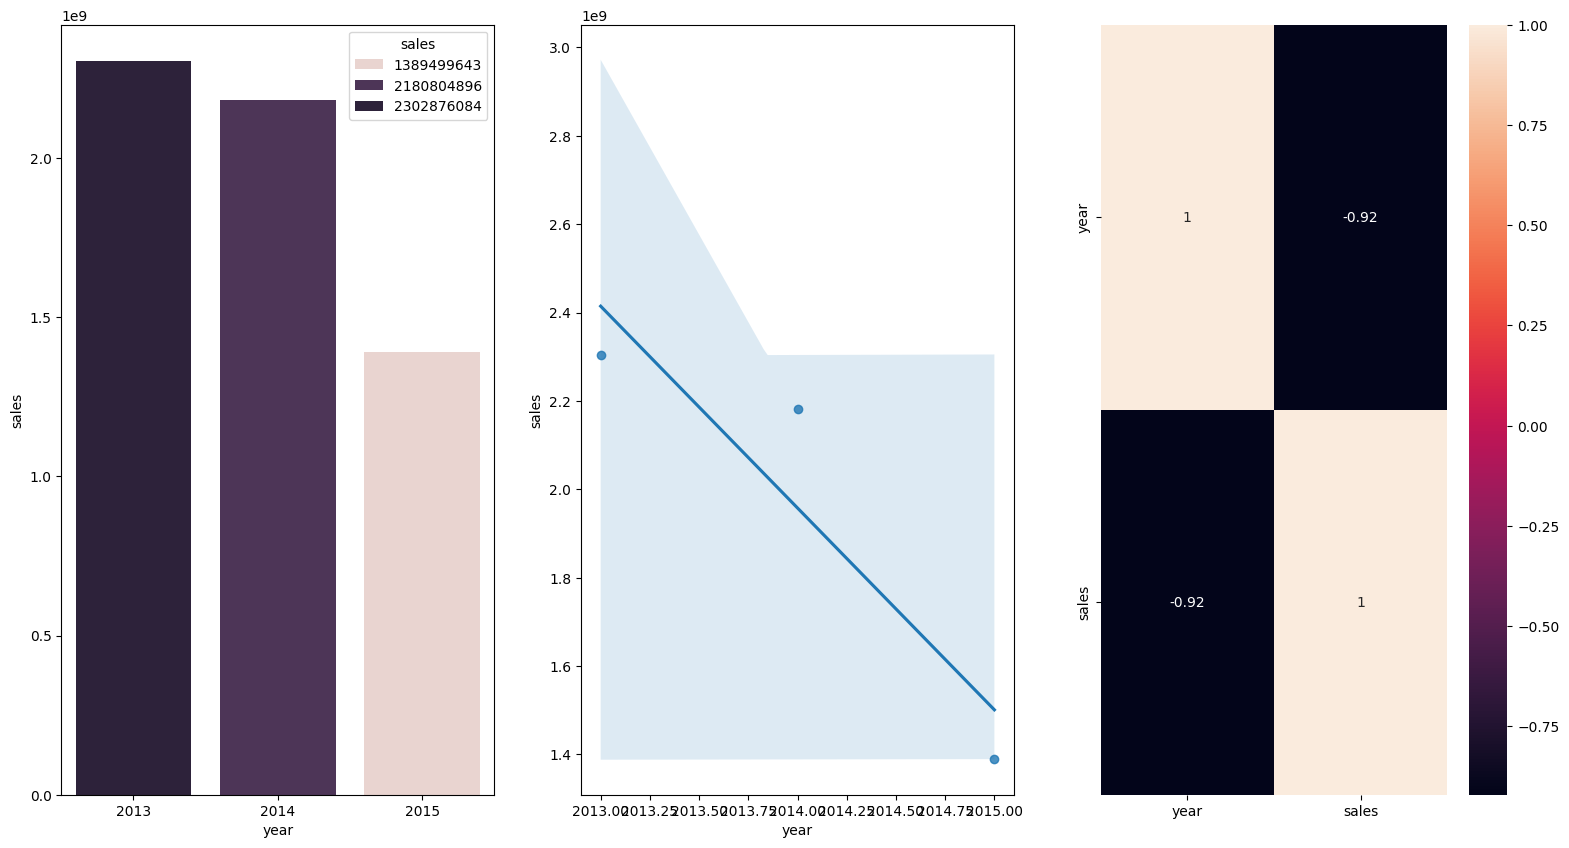

In [112]:
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H10 - Lojas deveriam vender mais no segundo semestre do ano
#### **FALSO** Lojas vendem menoss no 2 semestre do ano

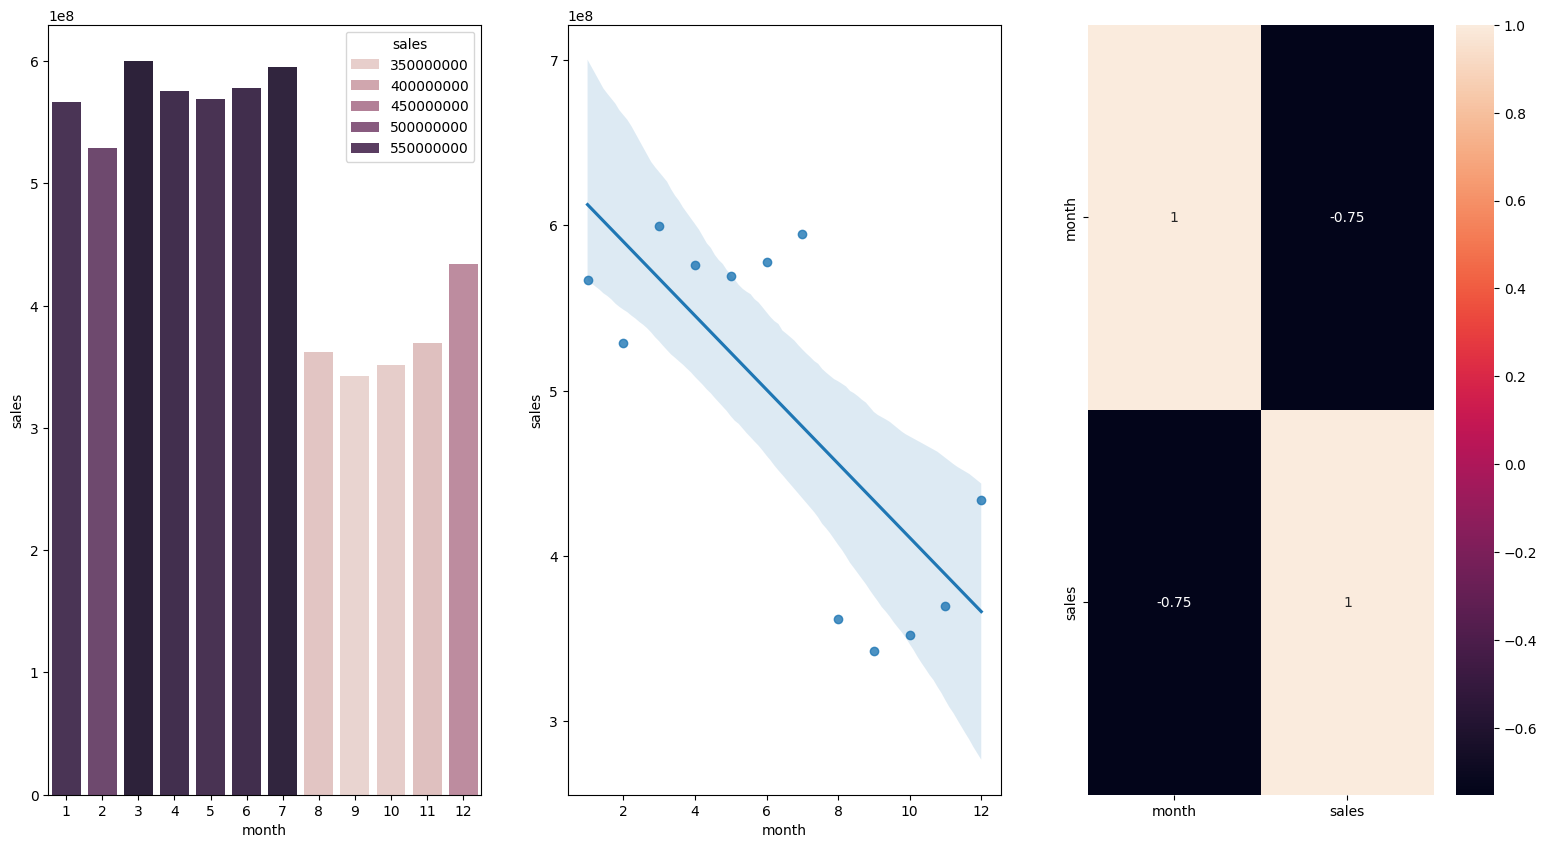

In [113]:
aux1 = df4[['month', 'sales']].groupby(['month']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H11 - Lojas deveriam vender mais depois do dia 10 de cada mês
### **VERDADEIRO** - lojas vendem mais depois do dia 10 de cada mês

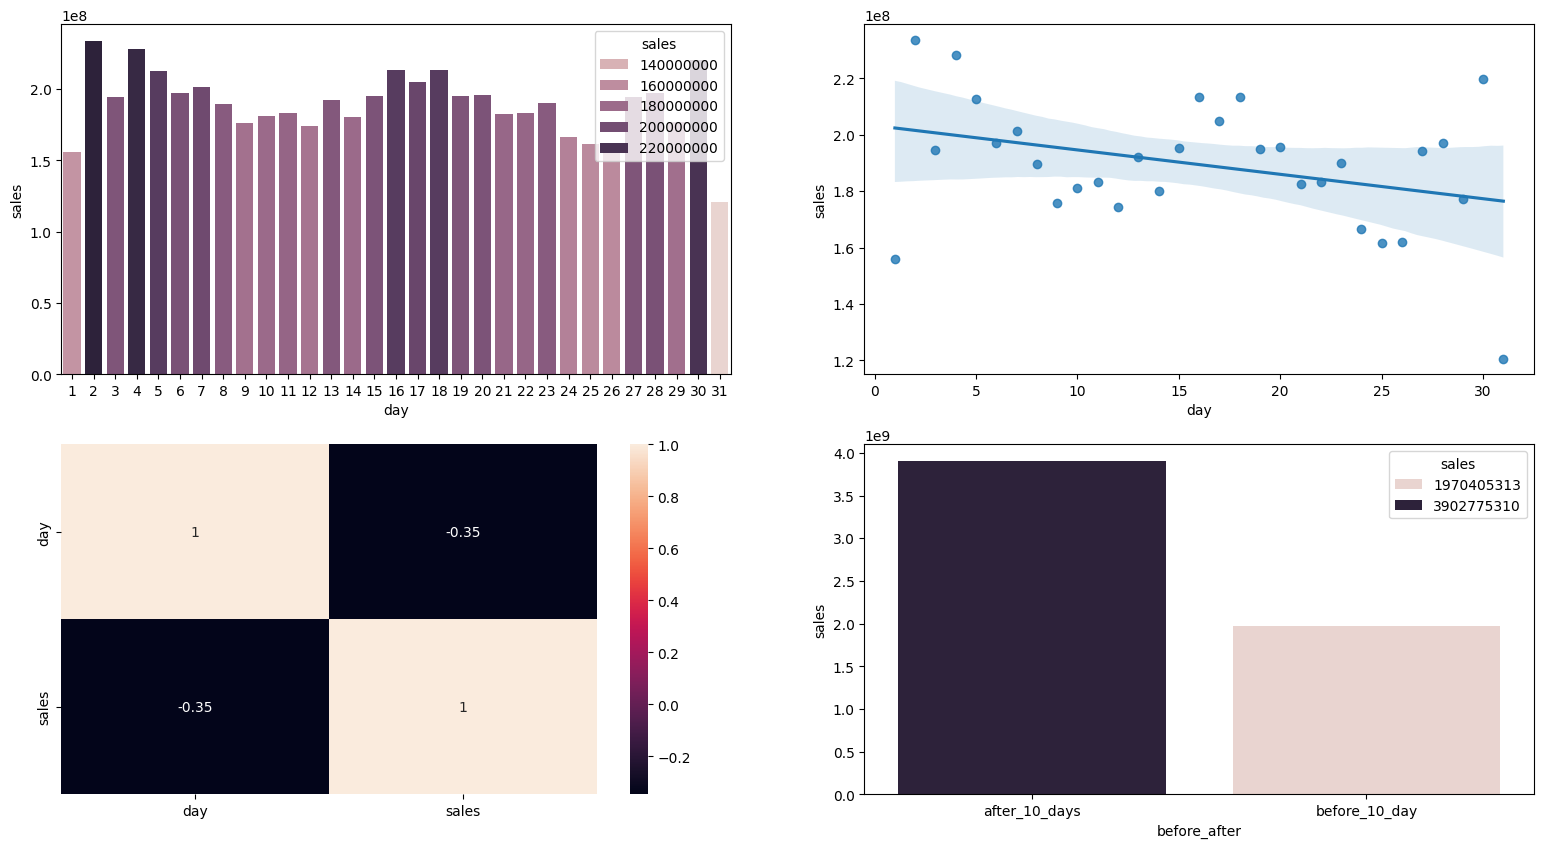

In [127]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1, hue='sales');

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2, hue='sales');


### H12 - Lojas deveriam vender menos aos finais de semana
#### **VERDADEIRA** - Lojas vendem menos nos finais de semana

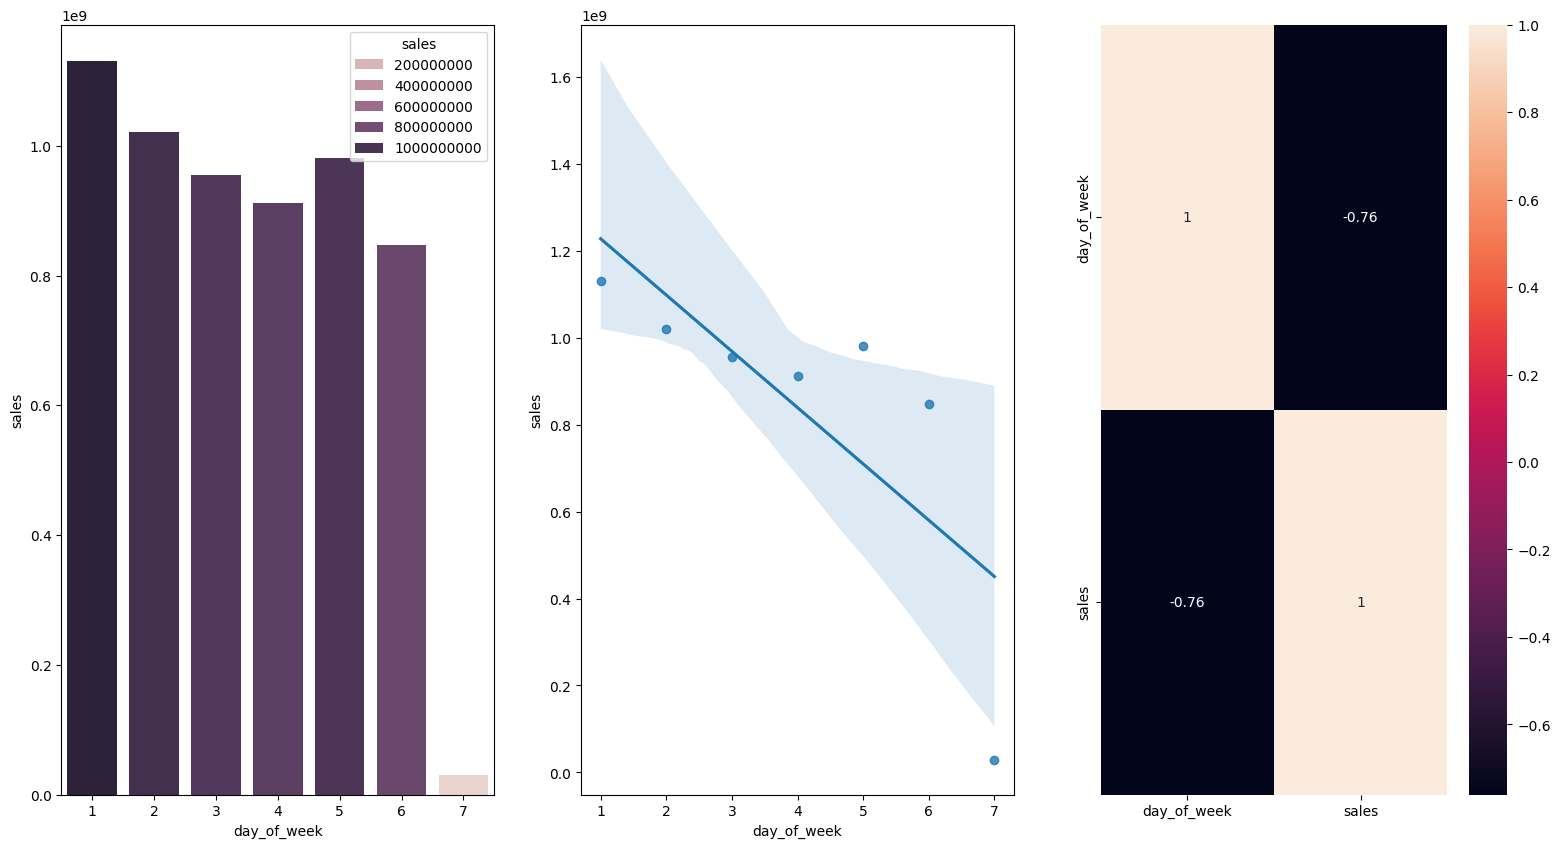

In [128]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H13 - Lojas deveriam vender menos durante os feriados escolares
#### **VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

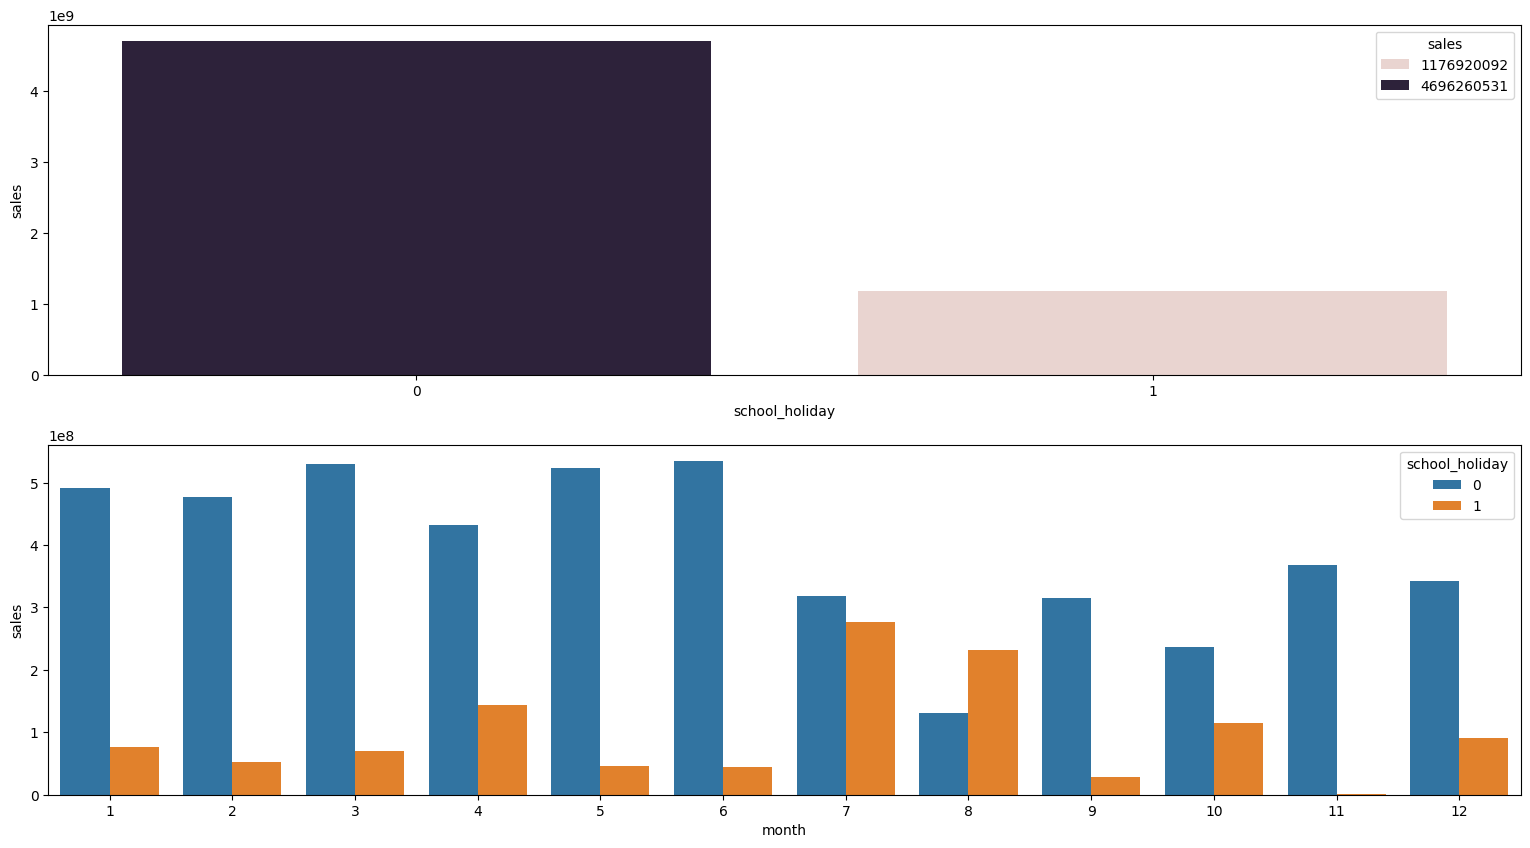

In [132]:
aux1 = df4[['school_holiday', 'sales']].groupby(['school_holiday']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1, hue='sales');

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

## 4.3 Analise Multivariada